### Cell type classification using arbor density representations

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [ ]:
%matplotlib inline

#### Training models

In [2]:
# Load arbor densities
rootdir = '../..'
datadir = os.path.join(rootdir, 'data')
csv_file1 = os.path.join(datadir, 'dataset', 'hist2d', 'manual.csv')
dfs1 = pd.read_csv(csv_file1)
specimen_ids1 = dfs1.specimen_id.values
specimens1 = list(specimen_ids1)
t_type1 = dfs1['VISp Tree Mapping'].values
soma_depth1 = np.array(dfs1['soma_depth_manual'])
csv_file2 = os.path.join(datadir, 'dataset', 'hist2d', 'auto.csv')
dfs2 = pd.read_csv(csv_file2)
specimen_ids2 = dfs2.specimen_id.values
specimens2 = list(specimen_ids2)
t_type2 = dfs2['VISp Tree Mapping'].values
soma_depth2 = np.array(dfs2['soma_depth_auto'])
specimen_ids = np.concatenate((specimen_ids1, specimen_ids2))
specimens = list(specimen_ids)
t_type = np.concatenate((t_type1, t_type2))
soma_depth = np.concatenate((soma_depth1, soma_depth2))
indir1 = os.path.join(datadir, 'dataset', 'hist2d', 'hist2d_manual')
indir2 = os.path.join(datadir, 'dataset', 'hist2d', 'hist2d_auto')
outdir = os.path.join(rootdir, 'results', 'classifier')
if not os.path.isdir(outdir):
    os.mkdir(outdir)

rbin_size = 4
zbin_size = 120

mdata = np.zeros((len(specimens1), zbin_size, rbin_size, 2))
for i, sp in enumerate(specimens1):
    fname = os.path.join(indir1, 'hist2d_%dx%d_axon_%s.csv'%(zbin_size, rbin_size, sp))
    mdata[i,:,:,0] = np.loadtxt(fname,delimiter=',')
    fname = os.path.join(indir1, 'hist2d_%dx%d_dendrite_%s.csv'%(zbin_size, rbin_size, sp))
    mdata[i,:,:,1] = np.loadtxt(fname,delimiter=',')
    
adata = np.zeros((len(specimens2), zbin_size, rbin_size, 2))
for i, sp in enumerate(specimens2):
    fname = os.path.join(indir2, 'hist2d_%dx%d_axon_%s.csv'%(zbin_size, rbin_size, sp))
    adata[i,:,:,0] = np.loadtxt(fname,delimiter=',')
    fname = os.path.join(indir2, 'hist2d_%dx%d_dendrite_%s.csv'%(zbin_size, rbin_size, sp))
    adata[i,:,:,1] = np.loadtxt(fname,delimiter=',')

hdata = np.concatenate((mdata, adata))   

# Create soma depth feature
fdata = np.expand_dims(soma_depth, axis=1)
fdata = fdata - np.min(fdata)
fdata = fdata/np.linalg.norm(fdata, ord=2)*100
sf = np.mean(fdata)/np.mean(soma_depth)

# Create labels
t_type_unique, num_unique = np.unique(t_type, return_counts=True)

labels = np.zeros((t_type.shape))
for i in range(len(labels)):
    labels[i] = (np.where(t_type_unique == t_type[i]))[0][0]

# Select types with number of cells > 4
select = np.where(num_unique > 4)

# Use 42 t-types to match feature-based classifier
idx_type = [1,2,0,13,11,12,38,39,41,37,33,40,35,36,34,16,23,29,30,14,15,25,24,17,31,22,
            21,19,18,20,32,27,28,26,4,8,3,7,5,6,9,10]

t_type_unique = t_type_unique[select][idx_type]
num_unique = num_unique[select][idx_type]

labels = np.ones((t_type.shape), dtype=int)*100
for i in range(len(labels)):
    if t_type[i] in t_type_unique:
        labels[i] = np.where(t_type_unique==t_type[i])[0][0]

select2 = [i for i in range(len(t_type)) if t_type[i] in t_type_unique]

hdata = hdata[select2,:,:,:]
fdata = fdata[select2,:]
labels = labels[select2]
t_type = t_type[select2]
specimen_ids = specimen_ids[select2]
soma_depth = soma_depth[select2]

# Create weights
num_select = np.zeros((t_type_unique.shape), dtype=int)
for i in range(len(t_type_unique)):
    num_select[i] = np.sum(labels==i) 
weights = 1./num_select

# Shuffle data and labels
shuffled_idx = np.arange(labels.shape[0])
np.random.seed(1)
np.random.shuffle(shuffled_idx)
labels = labels[shuffled_idx]
hdata = hdata[shuffled_idx,:,:,:]
fdata = fdata[shuffled_idx,:]
soma_depth = soma_depth[shuffled_idx]

# For each cell type calculate a range of relative soma depths
soma_depth_range = np.zeros((len(t_type_unique),2))
for i in range(len(t_type_unique)):
    select = np.where(labels==i)
    soma_depth_range[i,:] = np.array([np.min(soma_depth[select]), np.max(soma_depth[select])])

# For each cell calculate shift range   
sdata = np.zeros((len(t_type),2), dtype=int)
for i in range(len(t_type)):
    sdata[i,:] = np.round((soma_depth_range[int(labels[i])] - soma_depth[i])*100).astype(int)

hdim_in = zbin_size, rbin_size, 2
fdim_in = 85
channel_count = 1
conv_kernel_size = 7, 3, 1
kernel_size = [(4, 1, 1), (3, 1, 1)]
num_class = len(t_type_unique)
num_epochs = 2
bat_size = 675
learning_rate = 1e-3
log_interval = 1

# Create noise image
noise = np.zeros((1000,120,4))
for i in range(noise.shape[0]):
    n = np.random.rand(120,4)
    n = cv2.blur(n,(3,3))
    noise[i,:,:] = (n - np.mean(n[:]))/(np.max(n[:]) - np.min(n[:]))*2*0.8 +1 

In [3]:
class Net(nn.Module):
    def __init__(self, dim1, dim2, ch_count, conv_ksize, ksize, n_class):
        super(Net, self).__init__()
        
        self.dim = dim1
        self.ch_count = ch_count
        self.ksize = ksize
        
        self.conv1 = nn.Conv3d(1, ch_count, conv_ksize, padding=(conv_ksize[0]//2, conv_ksize[1]//2, 0))
        self.pool1 = nn.MaxPool3d(ksize[0])
        self.pool2 = nn.MaxPool3d(ksize[1])
        self.drop1 = nn.Dropout(p=0.6)
        
        self.fc1 = nn.Linear(dim2, 50)
        self.fc2 = nn.Linear(50,50)
        self.drop2 = nn.Dropout(p=0.6)
        
        self.fc3 = nn.Linear(ch_count*dim1[0]//ksize[0][0]//ksize[1][0]*dim1[1]//ksize[0][1]//ksize[1][1]*
                             dim1[2]//ksize[0][2]//ksize[1][2] + 1, n_class)
    
    def aug_noise(self, h, n):
        if self.training:
            rand_idx = torch.randint(0, n.shape[0], (h.shape[0],), dtype=torch.long)
            n = n[rand_idx,:,:]
            for j in range(2): 
                h[:,0,:,:,j] = torch.mul(h[:,0,:,:,j],n)  
        return h
    
    def shift3d(self, arr, num, fill_value=0):
        result = torch.empty_like(arr)
        if num > 0:
            result[:num,:,:] = fill_value
            result[num:,:,:] = arr[:-num,:,:]
        elif num < 0:
            result[num:,:,:] = fill_value
            result[:num,:,:] = arr[-num:,:,:]
        else:
            result = arr
        return result
    
    def aug_shift_range(self, h, s):
        if self.training:
            zmax = h.shape[2]
            rand_shifts = np.zeros((h.shape[0],), dtype=int)
            for i in range(h.shape[0]):
                shift_low = s[i,0].item()
                shift_high = s[i,1].item()
                select = torch.nonzero(h[i,0,:,:,:])
                zrange = torch.min(select[:,0]).item(), torch.max(select[:,0]).item()
                low = -np.minimum(zrange[0], abs(shift_low))
                high = np.minimum(zmax-zrange[1], shift_high)
                rand_shifts[i] = np.random.randint(low, high + 1)
                h[i,0,:,:,:] = self.shift3d(h[i,0,:,:,:], rand_shifts[i])
        else:
            rand_shifts = None
        return (h, rand_shifts)    
    
    def aug_fnoise(self, f):
        if self.training:
            mu = torch.ones_like(f)
            n = torch.normal(mu,std=0.2)
            f = torch.mul(f,n)  
        return f   
    
    def aug_soma_depth(self, f, s):
        if self.training:
            for i in range(f.shape[0]):
                f[i,:] = f[i,:] + s[i]/100*sf
        return f      
    
    def forward(self, x1, x2, rnoise, shifts):
        x1 = self.aug_noise(x1, rnoise)
        (x1, rs) = self.aug_shift_range(x1, shifts)
        x1 = self.pool1(F.relu(self.conv1(x1)))
        x1 = self.pool2(F.relu(self.conv1(x1)))
        x1 = x1.view(-1, self.ch_count*self.dim[0]//self.ksize[0][0]//self.ksize[1][0]*
                  self.dim[1]//self.ksize[0][1]//self.ksize[1][1]*
                  self.dim[2]//self.ksize[0][2]//self.ksize[1][2])
        
        x2 = self.aug_fnoise(x2)
        x2 = self.aug_soma_depth(x2, rs)
                
        x = torch.cat((x1,x2), dim=1)
        x = self.fc3(x)
        return x

In [4]:
def train(epoch, rnoise):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch_idx, (inputs1, inputs2, shifts, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs1, inputs2, rnoise, shifts)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, prediction = torch.max(outputs.data, 1)
        train_acc += torch.sum(prediction == targets.data).item()
    
    return train_loss / len(train_loader.dataset), train_acc / len(train_loader.dataset)

In [5]:
def test(epoch, rnoise):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for i, (inputs1, inputs2, shifts, targets) in enumerate(test_loader):
            outputs = model(inputs1, inputs2, rnoise, shifts)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, prediction = torch.max(outputs.data, 1)
            test_acc += torch.sum(prediction == targets.data).item()
    
    return test_loss / len(test_loader.dataset), test_acc / len(test_loader.dataset)

In [6]:
savedir = os.path.join(outdir, 'manual_auto')
if not os.path.isdir(savedir):
    os.mkdir(savedir)

In [7]:
# Run cross-validation
fold_num = 10
fold_size = int(np.ceil(labels.shape[0]/fold_num))
noise_tensor = torch.from_numpy(noise).type(torch.FloatTensor)

train_loss_all = np.zeros((fold_num, num_epochs))
train_acc_all = np.zeros((fold_num, num_epochs))
test_loss_all = np.zeros((fold_num, num_epochs))
test_acc_all = np.zeros((fold_num, num_epochs))
best_acc = np.zeros((fold_num,))

for i in range(fold_num):
    # Create train/test sets
    if i == fold_num - 1:
        test_idx = np.arange(i*fold_size, labels.shape[0])
    else:
        test_idx = np.arange(i*fold_size, (i+1)*fold_size)
    train_idx = np.setdiff1d(np.arange(labels.shape[0]),test_idx)    
    hdata_train = hdata[train_idx,:,:,:]
    fdata_train = fdata[train_idx,:]
    sdata_train = sdata[train_idx,:]
    labels_train = labels[train_idx]
    hdata_test = hdata[test_idx,:,:,:]
    fdata_test = fdata[test_idx,:]
    sdata_test = sdata[test_idx,:]
    labels_test = labels[test_idx]
    num_class = len(np.unique(labels_train))
    print('fold ', i)

    # Load data
    train_hdata = torch.from_numpy(np.expand_dims(hdata_train, axis=1)).type(torch.FloatTensor)
    train_fdata = torch.from_numpy(fdata_train).type(torch.FloatTensor)
    train_sdata = torch.from_numpy(sdata_train).type(torch.LongTensor)
    train_labels = torch.from_numpy(labels_train).type(torch.LongTensor)

    test_hdata = torch.from_numpy(np.expand_dims(hdata_test, axis=1)).type(torch.FloatTensor)
    test_fdata = torch.from_numpy(fdata_test).type(torch.FloatTensor)
    test_sdata = torch.from_numpy(sdata_test).type(torch.LongTensor)
    test_labels = torch.from_numpy(labels_test).type(torch.LongTensor)

    train_set = torch.utils.data.TensorDataset(train_hdata, train_fdata, train_sdata, train_labels)
    test_set = torch.utils.data.TensorDataset(test_hdata, test_fdata, test_sdata, test_labels)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_idx), shuffle=True) 
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_idx), shuffle=False)

    # Setup model
    model = Net(dim1=hdim_in, dim2=fdim_in, ch_count=channel_count, conv_ksize=conv_kernel_size, 
                        ksize=kernel_size, n_class=num_class)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Run
    for epoch in range(num_epochs):
        train_loss_all[i,epoch], train_acc_all[i,epoch] = train(epoch, noise_tensor)
        test_loss_all[i,epoch], test_acc_all[i,epoch] = test(epoch, noise_tensor) 

        # Save the model if the test acc is greater than our current best
        if test_acc_all[i,epoch] > best_acc[i]:
            torch.save(model.state_dict(), os.path.join(savedir,'fold%d_best.model'%i))
            print("Checkpoint saved", epoch, test_acc_all[i,epoch])
            best_acc[i] = test_acc_all[i,epoch]

    # Save the last model  
    torch.save(model.state_dict(), os.path.join(savedir,'fold%d_nepoch%d.model'%(i, num_epochs)))

fold  0
Checkpoint saved 0 0.02666666666666667
fold  1
Checkpoint saved 0 0.02666666666666667
fold  2
Checkpoint saved 0 0.10666666666666667
fold  3
fold  4
Checkpoint saved 0 0.04
fold  5
Checkpoint saved 0 0.02666666666666667
fold  6
Checkpoint saved 0 0.013333333333333334
fold  7
fold  8
Checkpoint saved 0 0.05333333333333334
fold  9
Checkpoint saved 0 0.05555555555555555
Checkpoint saved 1 0.06944444444444445


#### Prediction using pre-trained models

In [8]:
def predict(rnoise):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    pred_all = torch.zeros(0, dtype=torch.long)
    targ_all = torch.zeros(0, dtype=torch.long)
    with torch.no_grad():
        for i, (inputs1, inputs2, shifts, targets) in enumerate(test_loader):
            outputs = model(inputs1, inputs2, rnoise, shifts)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, prediction = torch.max(outputs.data, 1)
            test_acc += torch.sum(prediction == targets.data).item()
            pred_all = torch.cat((pred_all,prediction.cpu()))
            targ_all = torch.cat((targ_all,targets.cpu()))
            
    print('====> Test loss: {:.8f}, Test accuracy: {:.8f}'.format(test_loss / len(test_loader.dataset),
          test_acc / len(test_loader.dataset)))
    
    return test_loss / len(test_loader.dataset), test_acc / len(test_loader.dataset), pred_all.numpy(), targ_all.numpy()

In [9]:
# Prediction using saved models
savedir = os.path.join(rootdir, 'data', 'models', 'classifier', 'all')
model_files = [f for f in os.listdir(savedir) if 'best' in f] 
prediction_all = np.zeros((0,))
targets_all = np.zeros((0,))
for i in range(fold_num):
    # Load model
    filename = [f for f in model_files if 'fold' + str(i) in f][0]
    model_path = os.path.join(savedir, filename) 
    model.load_state_dict(torch.load(model_path, map_location="cpu"))

    # Create train/test sets
    if i == fold_num - 1:
        test_idx = np.arange(i*fold_size, labels.shape[0])
    else:
        test_idx = np.arange(i*fold_size, (i+1)*fold_size)
    hdata_test = hdata[test_idx,:,:,:]
    fdata_test = fdata[test_idx,:]
    sdata_test = sdata[test_idx,:]
    labels_test = labels[test_idx]

    # Load test data
    test_hdata = torch.from_numpy(np.expand_dims(hdata_test, axis=1)).type(torch.FloatTensor)
    test_fdata = torch.from_numpy(fdata_test).type(torch.FloatTensor)

    test_labels = torch.from_numpy(labels_test).type(torch.LongTensor)
    test_sdata = torch.from_numpy(sdata_test).type(torch.LongTensor)
    test_set = torch.utils.data.TensorDataset(test_hdata, test_fdata, test_sdata, test_labels)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=bat_size, shuffle=False)

    # Run prediction
    test_loss_all, test_acc_all, prediction, targets = predict(noise_tensor)

    prediction_all = np.concatenate((prediction_all, prediction))
    targets_all = np.concatenate((targets_all, targets))

====> Test loss: 0.03882926, Test accuracy: 0.40000000
====> Test loss: 0.04073814, Test accuracy: 0.48000000
====> Test loss: 0.02731486, Test accuracy: 0.50666667
====> Test loss: 0.03387836, Test accuracy: 0.46666667
====> Test loss: 0.03636745, Test accuracy: 0.40000000
====> Test loss: 0.03318284, Test accuracy: 0.48000000
====> Test loss: 0.04844775, Test accuracy: 0.33333333
====> Test loss: 0.03750392, Test accuracy: 0.44000000
====> Test loss: 0.03060962, Test accuracy: 0.54666667
====> Test loss: 0.03050150, Test accuracy: 0.43055556


In [10]:
# Calculate t-type prediction accuracy
acc_all_type = np.zeros((fold_num,))
for i in range(fold_num):
    acc_fold = np.sum(prediction_all[i*fold_size:(i+1)*fold_size]
      ==targets_all[i*fold_size:(i+1)*fold_size])/len(prediction_all[i*fold_size:(i+1)*fold_size])
    acc_all_type[i] = acc_fold
acc_type_mean = np.mean(acc_all_type)
acc_type_std = np.std(acc_all_type)
print('type accuracy mean %.3f stdv %.3f'%(acc_type_mean, acc_type_std))   

# Calculate subclass prediction accuracy
true_labels = t_type_unique[np.uint8(targets_all)]
pred_labels = t_type_unique[np.uint8(prediction_all)]
pred_subclass = np.array([s.split(' ')[0] for s in pred_labels])
true_subclass = np.array([s.split(' ')[0] for s in true_labels])

acc_all_subclass = np.zeros((fold_num,))
for i in range(fold_num):
    acc_fold = np.sum(pred_subclass[i*fold_size:(i+1)*fold_size]
     ==true_subclass[i*fold_size:(i+1)*fold_size])/len(pred_subclass[i*fold_size:(i+1)*fold_size])
    acc_all_subclass[i] = acc_fold
acc_subclass_mean = np.mean(acc_all_subclass)
acc_subclass_std = np.std(acc_all_subclass)
print('subclass accuracy mean %.3f stdv %.3f'%(acc_subclass_mean, acc_subclass_std))

# Calculate weights for predictions and targets
targets_weights = np.zeros(targets_all.shape)
for i in range(len(targets_weights)):
    targets_weights[i] = weights[int(targets_all[i])] 

type accuracy mean 0.448 stdv 0.058
subclass accuracy mean 0.793 stdv 0.032


#### Plot confusion matrix for the classification of 42 t-types based on arbor density representations

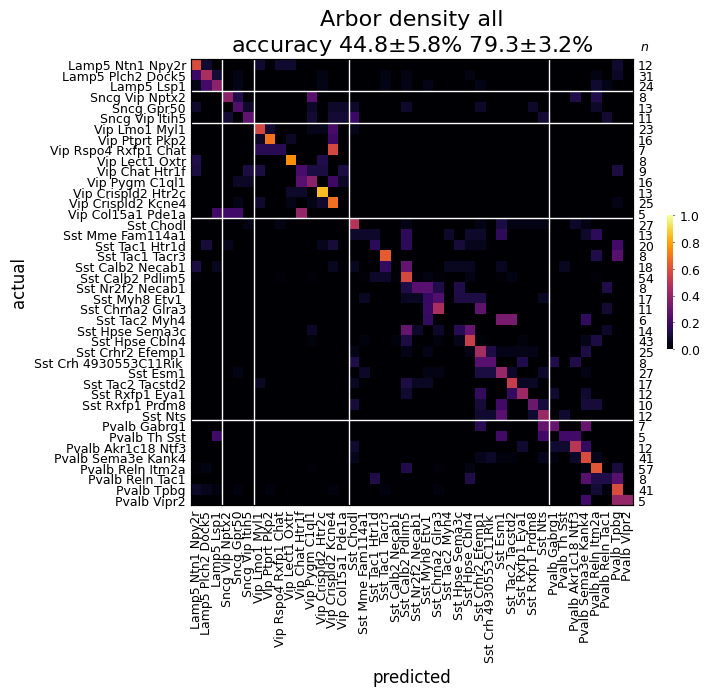

In [11]:
fig = plt.figure(figsize=(5.6,4.46))
plt.rcParams['font.size'] = '9'
ax=fig.add_axes([0,0,1,1])
par = ax.twinx()
p1 = ax.hist2d(prediction_all, targets_all, bins=num_class, range=[[0, num_class],[0,num_class]], 
           weights=targets_weights, cmap='inferno', vmax=1)
ax.set_ylim(ax.set_ylim()[::-1])
ax.vlines([3, 6, 15, 34], 0, 42, colors='w', linewidth=1) 
ax.hlines([3, 6, 15, 34], 0, 42, colors='w', linewidth=1) 
cb1 = fig.colorbar(p1[3], ax=ax, aspect=20, pad=0.06, shrink=0.3)
cb1.outline.set_visible(False)
cb1.ax.tick_params(size=1)
ax.yaxis.set_tick_params(labelleft=True)
ax.tick_params(length=0)
ax.set_xticks(np.arange(0.5,num_class))
ax.set_xticklabels(t_type_unique, rotation=90)
ax.set_yticks(np.arange(0.5,num_class))
ax.set_yticklabels(t_type_unique)
ax.set_xlabel('predicted', fontsize=12)
ax.set_ylabel('actual', fontsize=12)
par.set_ylim(ax.set_ylim()) # ensure correct tick location
par.yaxis.set_tick_params(labelright=True, length=0)
par.set_yticks(np.arange(0.5,num_class))
par.set_yticklabels(num_unique)
ax.text(42.7, -0.8, 'n', style='italic')
k = 100
plt.title('Arbor density all\naccuracy %.1f$\pm$%.1f'%(acc_type_mean*k, acc_type_std*k) + '%' 
           + ' %.1f$\pm$%.1f'%(acc_subclass_mean*k, acc_subclass_std*k) + '%', fontsize=16)
plt.show()